In [1]:
%matplotlib inline


# Spectral analysis



## Context

In classical Cherenkov astronomy,  1D spectral analysis consider all the events
inside a ON region and bin them in energy only.
The background estimation technique
associated with this method measures the number of events in OFF regions
taken in regions of the field-of-view devoid of gamma-ray emitters,
where the background rate is assumed to be equal to the one in the ON
region.

This allows to use a specific fit statistics for ON-OFF measurements,
the wstat (see `~gammapy.stats.wstat`), where no background model is
assumed. Background is treated as a set of nuisance parameters. This
removes some systematic effects connected to the choice or the quality
of the background model. But this comes at the expense of larger
statistical uncertainties on the fitted model parameters.

**Objective: perform a full region based spectral analysis of 4 Crab
observations of H.E.S.S. data release 1 and fit the resulting
datasets.**

## Introduction

We  will use the `~gammapy.data.DataStore` to retrieve a
list of selected observations (`~gammapy.data.Observations`). Then, we need to
define the ON region containing the source and the geometry of the
`~gammapy.datasets.SpectrumDataset` object we want to produce. We then
create the corresponding dataset Maker.

We have to define the Maker object that will extract the OFF counts from
reflected regions in the field-of-view. To ensure we use data in an
energy range where the quality of the IRFs is good enough we also create
a safe range Maker.

We can then proceed with data reduction with a loop over all selected
observations to produce datasets in the relevant geometry.

We can then explore the resulting datasets and look at the cumulative
signal and significance of our source. We finally proceed with model
fitting.

In practice, we have to:

- Create a `~gammapy.data.DataStore` pointing to the relevant data
- Apply an observation selection to produce a list of observations,
  a `~gammapy.data.Observations` object.
- Define a geometry of the spectrum we want to produce:

  - Create a `~regions.CircleSkyRegion` for the ON extraction region
  - Create a `~gammapy.maps.MapAxis` for the energy binnings: one for the
    reconstructed (i.e.measured) energy, the other for the true energy
    (i.e.the one used by IRFs and models)

- Create the necessary makers :

  - the spectrum dataset maker : `~gammapy.makers.SpectrumDatasetMaker` -
    the OFF background maker, here a `~gammapy.makers.ReflectedRegionsBackgroundMaker`
  - and the safe range maker : `~gammapy.makers.SafeMaskMaker`

- Perform the data reduction loop. And for every observation:

  - Apply the makers sequentially to produce a `~gammapy.datasets.SpectrumDatasetOnOff`
  - Append it to list of datasets


In [2]:
from pathlib import Path

# Check package versions
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from regions import CircleSkyRegion

# %matplotlib inline
import matplotlib.pyplot as plt

## Setup

As usual, we’ll start with some setup …




In [3]:
from IPython.display import display
from gammapy.data import DataStore
from gammapy.datasets import (
    Datasets,
    SpectrumDataset,
)
from gammapy.makers import (
    ReflectedRegionsBackgroundMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
)
from gammapy.maps import MapAxis, RegionGeom, WcsGeom


## Check setup



In [4]:
from gammapy.utils.check import check_tutorials_setup
from gammapy.visualization import plot_spectrum_datasets_off_regions

check_tutorials_setup()


System:

	python_executable      : /Users/qremy/anaconda3/envs/gpy-dev/bin/python 
	python_version         : 3.11.3     
	machine                : x86_64     
	system                 : Darwin     


Gammapy package:

	version                : 1.3.dev459+g3cad7bf0a 
	path                   : /Users/qremy/Work/GitHub/gammapy/gammapy 


Other packages:

	numpy                  : 1.23.5     
	scipy                  : 1.12.0     
	astropy                : 5.2.2      
	regions                : 0.7        
	click                  : 8.0.4      
	yaml                   : 6.0        
	IPython                : 8.12.0     
	jupyterlab             : not installed 
	matplotlib             : 3.8.0      
	pandas                 : 2.0.2      
	healpy                 : 1.16.2     
	iminuit                : 2.21.3     
	sherpa                 : not installed 
	naima                  : 0.10.0     
	emcee                  : 3.1.4      
	corner                 : 2.2.2      
	ray                    : 2.9.0 

## Load Data

First, we select and load some H.E.S.S. observations of the Crab nebula
(simulated events for now).

We will access the events, effective area, energy dispersion, livetime
and PSF for containment correction.




In [5]:
datastore = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1/")

In [6]:
datastore.obs_table

OBS_ID,RA_PNT,DEC_PNT,GLON_PNT,GLAT_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,OBJECT,RA_OBJ,DEC_OBJ,OFFSET_OBJ,ONTIME,LIVETIME,DEADC,TSTART,TSTOP,DATE-OBS,TIME-OBS,DATE-END,TIME-END,N_TELS,TELLIST,QUALITY,MUONEFF,EVENT_COUNT,TARGET_NAME,TARGET_TAG,TARGET_OFFSET,SAFE_ENERGY_LO,SAFE_ENERGY_HI
,deg,deg,deg,deg,deg,deg,deg,,deg,deg,deg,s,s,,s,s,,,,,,,,,,,,deg,TeV,TeV
int64,float32,float32,float32,float32,float32,float32,float32,bytes18,float32,float32,float32,float32,float32,float32,float64,float64,bytes10,bytes12,bytes10,bytes12,int64,bytes7,int64,float32,int64,bytes21,bytes14,float32,float32,float32
20136,228.6125,-58.771667,320.56754,-0.8857012,38.512962,51.487038,195.73102,MSH15-52,228.6125,-59.271667,0.5,1682.0,1521.0269,0.9042966,101962602.0,101964284.0,2004-03-26,02:57:46.184,2004-03-26,03:25:48.184,4,"1,2,3,4",0,1.2132596,11243,MSH 15-52,msh1552,0.38821736,0.40738028,100.0
20137,228.6125,-59.771667,320.04724,-1.7397733,40.21616,49.78384,199.6482,MSH15-52,228.6125,-59.271667,0.5,902.0,819.2054,0.90821,101964441.0,101965343.0,2004-03-26,03:28:25.184,2004-03-26,03:43:27.184,4,"1,2,3,4",0,1.2139559,5693,MSH 15-52,msh1552,0.6156251,0.40738028,100.0
20151,228.6125,-58.771667,320.56754,-0.8857012,37.164658,52.835342,190.97171,custom,228.6125,-59.271667,0.5,1683.0,1530.479,0.9093755,102047232.0,102048915.0,2004-03-27,02:28:16.184,2004-03-27,02:56:19.184,4,"1,2,3,4",0,1.2214733,10722,MSH 15-52,msh1552,0.38821736,0.40738028,100.0
20275,187.27792,2.552389,289.7155,64.849686,36.18243,53.81757,49.144917,3C 273,187.27792,2.052389,0.5,1683.0,1525.8447,0.90662193,103665036.0,103666719.0,2004-04-14,19:51:40.184,2004-04-14,20:19:43.184,4,"1,2,3,4",0,1.121256,10646,Off data,offdata,--,0.33113113,100.0
20282,228.6125,-58.771667,320.56754,-0.8857012,37.13134,52.86866,169.21602,MSH 15-5-02,228.6125,-59.271667,0.5,1687.0,1543.3231,0.9148329,103678269.0,103679956.0,2004-04-14,23:32:13.184,2004-04-15,00:00:20.184,4,"1,2,3,4",0,1.1495326,11063,MSH 15-52,msh1552,0.38821736,0.40738028,100.0
20283,228.6125,-59.771667,320.04724,-1.7397733,36.221436,53.778564,175.77263,MSH 15-5-02,228.6125,-59.271667,0.5,1683.0,1547.8253,0.9196823,103680087.0,103681770.0,2004-04-15,00:02:31.184,2004-04-15,00:30:34.184,4,"1,2,3,4",0,1.1512518,7628,MSH 15-52,msh1552,0.6156251,0.3801894,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47802,330.29538,-30.225555,17.818897,-52.742733,36.828686,53.171314,110.0,PKS 2155-304,329.71667,-30.225555,0.50002956,1688.0,1572.4065,0.9315204,241558291.0,241559979.0,2008-08-27,19:32:35.184,2008-08-27,20:00:43.184,4,"1,2,3,4",0,0.9731573,5998,PKS 2155-304 (steady),pks2155_steady,0.4998021,0.61659503,100.0


**Exercise:**
- Use the `datastore.obs_table` to display only `"Crab Nebula"` observations using the `OBJECT` column
- get list of their `OBS_ID` and use it to get a list of observations using `datastore.get_observations` method

In [7]:
target_name = "Crab Nebula"
selection = datastore.obs_table["OBJECT"]==target_name
datastore.obs_table[selection]

OBS_ID,RA_PNT,DEC_PNT,GLON_PNT,GLAT_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,OBJECT,RA_OBJ,DEC_OBJ,OFFSET_OBJ,ONTIME,LIVETIME,DEADC,TSTART,TSTOP,DATE-OBS,TIME-OBS,DATE-END,TIME-END,N_TELS,TELLIST,QUALITY,MUONEFF,EVENT_COUNT,TARGET_NAME,TARGET_TAG,TARGET_OFFSET,SAFE_ENERGY_LO,SAFE_ENERGY_HI
,deg,deg,deg,deg,deg,deg,deg,,deg,deg,deg,s,s,,s,s,,,,,,,,,,,,deg,TeV,TeV
int64,float32,float32,float32,float32,float32,float32,float32,bytes18,float32,float32,float32,float32,float32,float32,float64,float64,bytes10,bytes12,bytes10,bytes12,int64,bytes7,int64,float32,int64,bytes21,bytes14,float32,float32,float32
23523,83.63333,21.514444,184.9823,-6.0516925,48.61021,41.38979,22.481705,Crab Nebula,83.63333,22.014444,0.5,1687.0,1581.7368,0.9376033,123890826.0,123892513.0,2004-12-04,22:08:10.184,2004-12-04,22:36:17.184,4,"1,2,3,4",0,0.9070748,7613,Crab,crab,0.500049,0.8709636,100.0
23526,83.63333,22.514444,184.13332,-5.5163794,45.77929,44.22071,8.542603,Crab Nebula,83.63333,22.014444,0.5,1683.0,1572.6868,0.9344544,123893580.0,123895263.0,2004-12-04,22:54:04.184,2004-12-04,23:22:07.184,4,"1,2,3,4",0,0.9142412,7581,Crab,crab,0.49995112,0.70794576,100.0
23559,85.253334,22.014444,185.35727,-4.510869,45.368176,44.631824,2.2535799,Crab Nebula,83.63333,22.014444,1.5018803,1686.0,1578.1235,0.9360163,124067051.0,124068737.0,2004-12-06,23:05:15.184,2004-12-06,23:33:21.184,4,"1,2,3,4",0,0.91964024,7601,Crab,crab,1.5021166,0.66069347,100.0
23592,82.013336,22.014444,183.7408,-7.047852,48.389248,41.610752,21.7556,Crab Nebula,83.63333,22.014444,1.5018733,1686.0,1581.2646,0.9378794,124235636.0,124237322.0,2004-12-08,21:55:00.184,2004-12-08,22:23:06.184,4,"1,2,3,4",0,0.9120389,7334,Crab,crab,1.5016365,0.8709636,100.0


In [8]:
obs_ids = datastore.obs_table[selection]["OBS_ID"]
observations = datastore.get_observations(obs_ids)

## How to choose the ON region size and the exclusion region sizes ?

Typically for point sources the ON region size is chosen to match the 68% containment radius of the PSF, while the exclusion region radius used to mask nearby sources is set to the 95% or 99% containment radius of the PSF. For extended sources one can consider the quadratic sum of the source radius and PSF radius.


In [9]:
obs0 = observations[0]
print(obs0.psf.info(
      fraction=[0.68, 0.95, 0.99, 0.68, 0.95, 0.99],
      energy_true=[1., 1., 1., 10, 10, 10]*u.TeV,
      offset=[0, 0, 0, 0, 0, 0]*u.deg)
     )


Summary PSF info
----------------
Theta          : size =     6, min =  0.000 deg, max =  2.500 deg
Energy hi      : size =    32, min =  0.013 TeV, max = 100.000 TeV
Energy lo      : size =    32, min =  0.010 TeV, max = 74.989 TeV
68.00 containment radius at offset = 0.0 deg and energy_true =  1.0 TeV: 0.123 deg
95.00 containment radius at offset = 0.0 deg and energy_true =  1.0 TeV: 0.301 deg
99.00 containment radius at offset = 0.0 deg and energy_true =  1.0 TeV: 0.479 deg
68.00 containment radius at offset = 0.0 deg and energy_true = 10.0 TeV: 0.108 deg
95.00 containment radius at offset = 0.0 deg and energy_true = 10.0 TeV: 0.367 deg
99.00 containment radius at offset = 0.0 deg and energy_true = 10.0 TeV: 0.555 deg



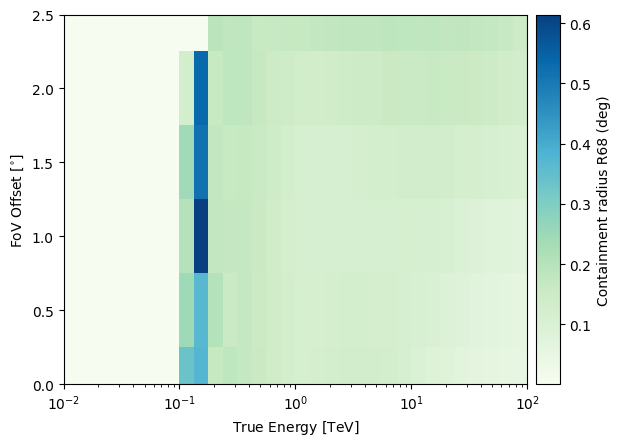

In [10]:
observations[0].psf.plot_containment_radius(fraction=0.68);


Here for simplicity we are are going to consider the median value in energy at offset zero for one observation. Ideally one should define for each observation an energy-dependent on-region at the offset matching the separation between the observation and target position.

In [11]:
on_region_radius = np.median(obs0.psf.containment_radius(fraction=0.68,
      energy_true=obs0.psf.axes["energy_true"].center,
      offset=0*u.deg))
print(on_region_radius)

0.1081318302080035 deg


and we do the same for the exclusion radius

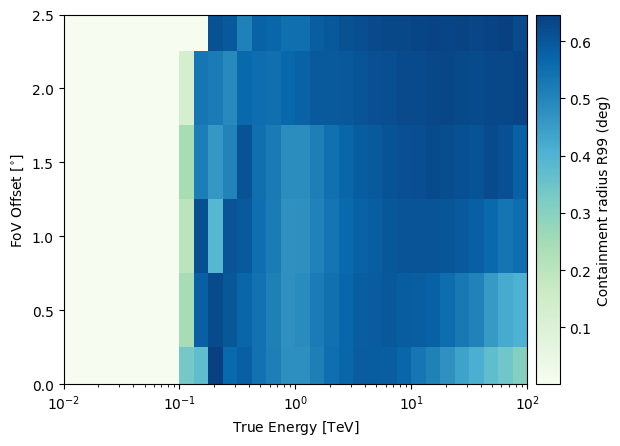

In [12]:
obs0.psf.plot_containment_radius(fraction=0.99);

In [13]:
exclusion_radius = np.median(obs0.psf.containment_radius(fraction=0.99,
      energy_true=obs0.psf.axes["energy_true"].center,
      offset=0*u.deg))
print(exclusion_radius)

0.4757364951074122 deg


## Define Target Region

The next step is to define a signal extraction region, also known as on
region. In the simplest case this is just a
[CircleSkyRegion](http://astropy-regions.readthedocs.io/en/latest/api/regions.CircleSkyRegion.html)_.




In [14]:
target_position = SkyCoord.from_name("Crab Nebula").icrs
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

## Create exclusion mask

We will use the reflected regions method to place off regions to
estimate the background level in the on region. To make sure the off
regions don’t contain gamma-ray emission, we create an exclusion mask.

Using http://gamma-sky.net/ we find that there’s only one known
gamma-ray source near the Crab nebula: the AGN called [RGB
J0521+212](http://gamma-sky.net/#/cat/tev/23)_ at GLON = 183.604 deg
and GLAT = -8.708 deg.




In [15]:
excluded_source =  "RGB J0521+212"
excluded_position = SkyCoord.from_name("RGB J0521+212").galactic
print(excluded_position)

<SkyCoord (Galactic): (l, b) in deg
    (183.60416634, -8.70833339)>


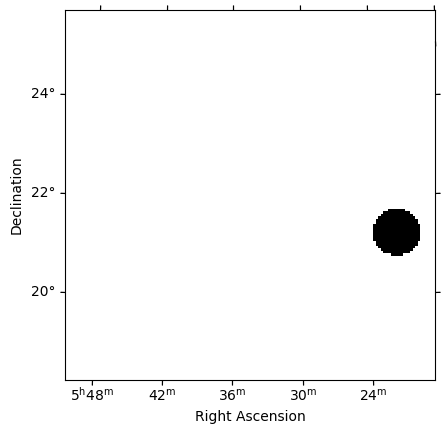

In [16]:
exclusion_region = CircleSkyRegion(
    center=excluded_position,
    radius=exclusion_radius,
)

skydir = target_position.galactic
geom = WcsGeom.create(
    npix=(150, 150), binsz=0.05, skydir=skydir, proj="TAN", frame="icrs"
)

exclusion_mask = ~geom.region_mask([exclusion_region])
exclusion_mask.plot()
plt.show()

## Dataset definition


In [17]:
energy_axis = MapAxis.from_energy_bounds(
    0.1, 40, nbin=10, per_decade=True, unit="TeV", name="energy"
)
energy_axis_true = MapAxis.from_energy_bounds(
    0.05, 100, nbin=20, per_decade=True, unit="TeV", name="energy_true"
)

geom = RegionGeom.create(region=on_region, axes=[energy_axis])
dataset_empty = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)


## Data reduction


We begin with the configuration of the maker classes:


In [18]:

dataset_maker = SpectrumDatasetMaker(
    containment_correction=True, selection=["counts", "exposure", "edisp"]
)
safe_mask_masker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)
bkg_maker = ReflectedRegionsBackgroundMaker(exclusion_mask=exclusion_mask)


then we run data data reduction chain (try using the `DatasetsMaker` instead of the following loop)


In [19]:
datasets = Datasets()

for obs_id, observation in zip(obs_ids, observations):
    dataset = dataset_maker.run(dataset_empty.copy(name=f"_hess_obs{obs_id}"), observation)
    dataset_on_off = bkg_maker.run(dataset, observation)
    dataset_on_off = safe_mask_masker.run(dataset_on_off, observation)
    datasets.append(dataset_on_off)

print(datasets)

Datasets
--------

Dataset 0: 

  Type       : SpectrumDatasetOnOff
  Name       : _hess_obs23523
  Instrument : HESS
  Models     : 

Dataset 1: 

  Type       : SpectrumDatasetOnOff
  Name       : _hess_obs23526
  Instrument : HESS
  Models     : 

Dataset 2: 

  Type       : SpectrumDatasetOnOff
  Name       : _hess_obs23559
  Instrument : HESS
  Models     : 

Dataset 3: 

  Type       : SpectrumDatasetOnOff
  Name       : _hess_obs23592
  Instrument : HESS
  Models     : 




## Plot off regions




/Users/qremy/anaconda3/envs/gpy-dev/lib/python3.11/site-packages/regions/shapes/circle.py:161: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Circle(xy=xy, radius=radius, **mpl_kwargs)
/Users/qremy/Work/GitHub/gammapy/gammapy/visualization/datasets.py:84: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handle = Patch(**plot_kwargs)


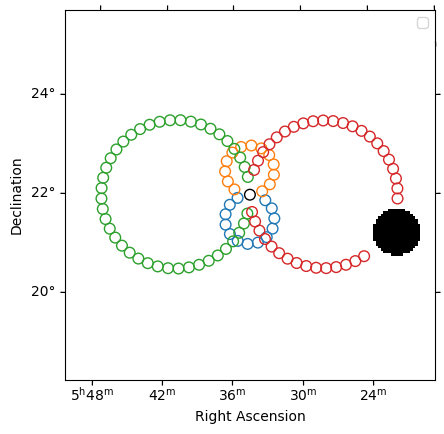

In [20]:
plt.figure()
ax = exclusion_mask.plot()
on_region.to_pixel(ax.wcs).plot(ax=ax, edgecolor="k")
plot_spectrum_datasets_off_regions(ax=ax, datasets=datasets)
plt.show()

## Source statistic

Next we’re going to look at the overall source statistics in our signal
region.




In [21]:
info_table = datasets.info_table(cumulative=True)

display(info_table)

name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str7,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
stacked,148,137.84616088867188,20.334154211576056,10.153846740722656,20.000000691839627,20.000000691839627,nan,2844281.0,836522688.0,1581.736764695497,1687.0000000000016,0.09356803439318916,0.006419428926075062,0.08714861029054281,27,18,wstat,427.0906990061865,132,18.0,233.99998474121094,0.07692307978868484
stacked,298,275.4615478515625,28.23203420482605,22.538461685180664,42.214286461472504,42.214286461472504,nan,13171474.0,1563979904.0,3154.4235137812757,3369.9999999999964,0.09447051060140652,0.00714503350191025,0.0873254801227882,27,19,wstat,811.6747616218272,293,19.0,246.99998474121094,0.07692307978868484
stacked,435,404.532958984375,35.97650289058618,30.4670352935791,50.02029361685526,50.02029361685526,nan,18875320.0,2064834176.0,4732.546993609518,5056.000000000001,0.09191667839482458,0.0064377670913188054,0.08547891009442198,27,19,wstat,1310.7192127531077,626,19.0,390.3891296386719,0.04866938665509224
stacked,544,506.15460205078125,40.66150516476218,37.84540939331055,58.62142560163771,58.62142560163771,nan,20617616.0,2619246080.0,6313.811659421768,6741.999999999996,0.0861603147740743,0.005994066886178944,0.08016624970044417,27,19,wstat,1683.0392551589246,899,19.0,451.33612060546875,0.04209722951054573


And make the corresponding plots



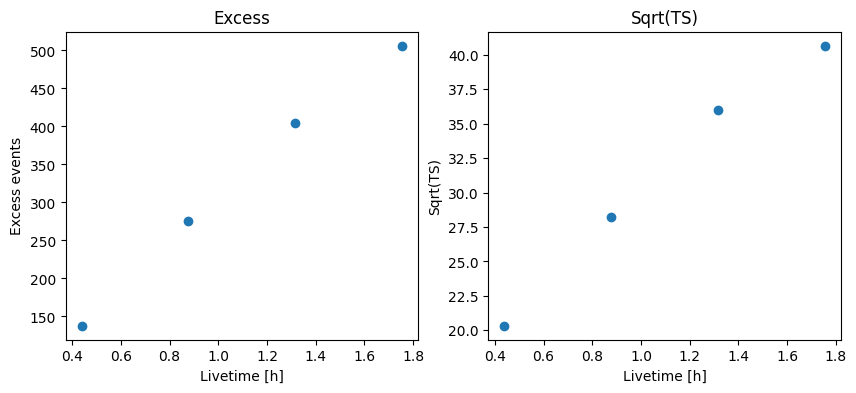

In [22]:
fig, (ax_excess, ax_sqrt_ts) = plt.subplots(figsize=(10, 4), ncols=2, nrows=1)
ax_excess.plot(
    info_table["livetime"].to("h"),
    info_table["excess"],
    marker="o",
    ls="none",
)

ax_excess.set_title("Excess")
ax_excess.set_xlabel("Livetime [h]")
ax_excess.set_ylabel("Excess events")

ax_sqrt_ts.plot(
    info_table["livetime"].to("h"),
    info_table["sqrt_ts"],
    marker="o",
    ls="none",
)

ax_sqrt_ts.set_title("Sqrt(TS)")
ax_sqrt_ts.set_xlabel("Livetime [h]")
ax_sqrt_ts.set_ylabel("Sqrt(TS)")
plt.show()

## Save the Datasets



In [23]:
path = Path("./datasets/crab_1d")
path.mkdir(exist_ok=True)

datasets.write(filename= path / "datasets_crab_1d.yaml", overwrite=True)

**Now you can check the modeling and fitting tutorial to read this dataset and analyse the data**